In [1]:
import pandas as pd
intron = pd.read_pickle('~/projects/intron.pickle')
exon = pd.read_pickle('~/projects/exon.pickle')
eclip_bam = pd.read_csv('/home/hsher/projects/peak_calling/ENCODE_FINAL_ANNOTATIONS.uidsonly.txt.manifesthg38.txt', sep = '\t', header= 0, index_col = 0)

In [2]:
eclip_bam.head()

,RBP,Cell line,CLIP_rep1,CLIP_rep2,INPUT
uID,,,,,
203,HNRNPC,HepG2,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...
204,RBFOX2,HepG2,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...
205,IGF2BP1,HepG2,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...
206,HNRNPK,HepG2,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...
209,SRSF7,HepG2,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...


In [3]:
len(eclip_bam['RBP'].unique())

150

In [4]:
# take a look at event type for RBPs
hep = pd.read_csv('~/projects/alt_splice/HepG2/RBP_eventtype.count',sep = r'\s+', header = None, names = ['count', 'event', 'RBP'])
k562 = pd.read_csv('~/projects/alt_splice/HepG2/RBP_eventtype.count', sep = r'\s+', header = None, names = ['count', 'event', 'RBP'])
hep = hep.pivot(index = 'event', columns = 'RBP').drop('event').fillna(0)
hep.columns = hep.columns.droplevel()

k562 = k562.pivot(index = 'event', columns = 'RBP').drop('event').fillna(0)
k562.columns = k562.columns.droplevel()


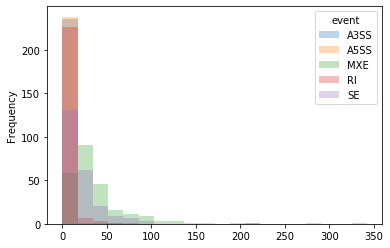

In [5]:
import matplotlib.pyplot as plt
k562.transpose().plot.hist(bins = 20, alpha = 0.3)

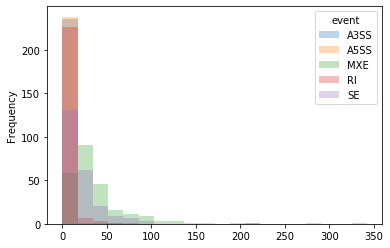

In [6]:
hep.transpose().plot.hist(bins = 20, alpha = 0.3)

# do number of eclip binding correspond to number of events?

In [7]:
def eclip_kd_comparison(kd, eclip_bam = eclip_bam, discretized_binding = intron, cell_line = 'HepG2'):
    rbp_id = eclip_bam.loc[eclip_bam['Cell line']== cell_line].index
    no_feature = discretized_binding.loc[discretized_binding.index.isin(rbp_id)].sum(axis = 1)
    no_feature.index = eclip_bam.loc[no_feature.index, 'RBP']
    effect = kd.loc[:,kd.columns.isin(eclip_bam.loc[rbp_id, 'RBP'])]
    
    # join data
    d = pd.concat([effect, no_feature.to_frame(name= 'no_feature').transpose()])
    return d.dropna(axis = 1)
    

In [8]:
hep_d = eclip_kd_comparison(hep)
k562_d = eclip_kd_comparison(k562, cell_line = 'K562')

In [9]:
hep_d['TIA1']

A3SS            6.0
A5SS            4.0
MXE            78.0
RI             19.0
SE             72.0
no_feature    547.0
Name: TIA1, dtype: float64

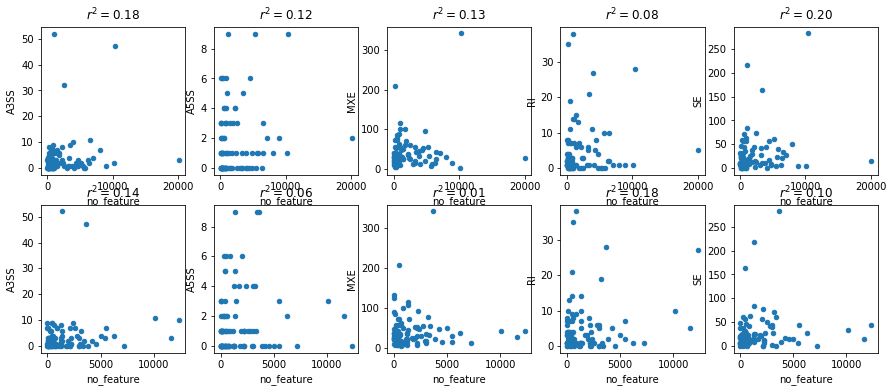

In [11]:
f,ax = plt.subplots(2,5, figsize = (15,6))
c = 0

for cell_line in [hep_d, k562_d]:
    i = 0
    for y in cell_line.index[:-1]:
        cell_line.transpose().plot(x = 'no_feature', y = y, kind = 'scatter', ax = ax[c, i])
        ax[c,i].set_title('$r^2=${:.2f}'.format(cell_line.transpose().corr().loc[y, 'no_feature']))
        i+=1
    c+= 1
        

# Does network components have similar effects in splicing?

In [12]:
network = pd.read_csv('~/projects/network/intron_exon_network', header = 0, index_col = 0)

In [31]:
# how much can be explained by direct interaction?
# overlap direct and indirect interaction

def overlap_splice(direct, indirect, cell_line):
    direct_target = set(pd.read_csv('/home/hsher/projects/alt_splice/{}/{}'.format(cell_line, direct), header = None, sep = '\t')[3])
    indirect_target = set(pd.read_csv('/home/hsher/projects/alt_splice/{}/{}'.format(cell_line, indirect), header = None, sep = '\t')[3])
    
    
    return len(direct_target.intersection(indirect_target))/len(direct_target.union(indirect_target))

In [14]:
network.head()

,score,jaccard_similarity_INTRON,jaccard_similarity_EXON,protein_one,protein_two
0,0.901,0.108018,0.032787,AQR,GPKOW
1,0.902,0.018849,0.007874,RBM22,GPKOW
2,0.903,0.019529,0.018182,GPKOW,PABPN1
3,0.900,0.063001,0.004373,GPKOW,HNRNPL
4,0.901,0.023862,0.000201,GPKOW,SRSF9


In [34]:
for i in network.index:
    for cell_line in ['HepG2', 'K562']:
        try:
            jac_event = overlap_splice(network.loc[i, 'protein_one'], network.loc[i, 'protein_two'], cell_line)
            network.loc[i, cell_line+'_splice_jac'] = jac_event
        except:
            pass
        

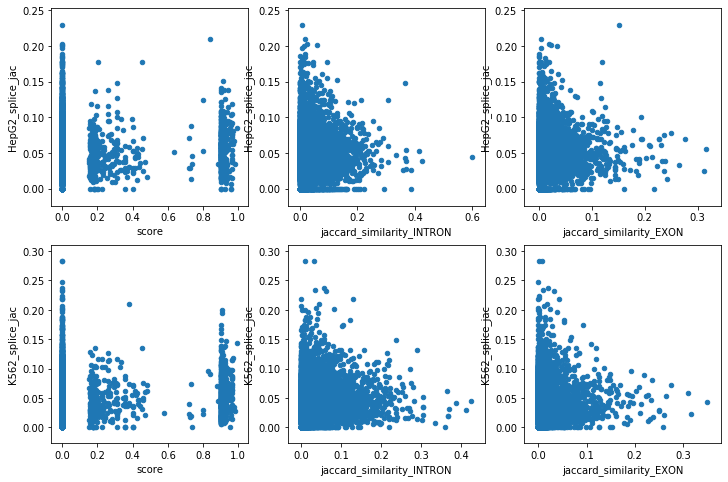

In [37]:
f, ax = plt.subplots(2,3, figsize = (12,8))
ax = ax.flatten('F')
n = 0
for i in ['score', 'jaccard_similarity_INTRON', 'jaccard_similarity_EXON']:
    for j in ['HepG2_splice_jac', 'K562_splice_jac']:
        network.plot(x = i, y = j, kind = 'scatter', ax = ax[n])
        n+=1
        